In [1]:
import My_functions as Mf
import os
from openpiv import tools, scaling, pyprocess, validation, filters, preprocess
import pathlib
import matplotlib.pyplot as plt
import numpy as np

c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


dynamic Mask?

if set True make sure to set static mask to False

In [2]:
Masked = False

define folders

In [3]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different

pic_folder = os.path.join(parent_folder, 'Picture', 'alot')
pic_folder = os.path.join(Mf.select_directory())

Expirement_date = Mf.read_data_from_cihx(pic_folder, '<date>')
Record_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])

save_folder = os.path.join(parent_folder, 'output', f'{Expirement_date.replace("/", " ")} - Rec {Record_number}')
save_folder_multy = os.path.join(save_folder, 'Multy')

# delete the Output folder?
if False: Mf.eliminate_folder(save_folder)


multy_cut_image = 'multy_cut_image'
if Masked:
    multy_cut_image = multy_cut_image+ '_masked'
multy_cut_image_folder = os.path.join(save_folder_multy, multy_cut_image)
Mf.create_directory(multy_cut_image_folder)

picture_list = Mf.find_pictures(pic_folder)
print(f'Expirement date = {Expirement_date}')
print(f'Record number - {Record_number}')

Expirement date = 2024/1/24
Record number - 1


scaling factor from camera cihx

In [4]:
unit = Mf.read_data_from_cihx(pic_folder, '<distanceUnit>')
scaling_factor = 1/Mf.read_data_from_cihx(pic_folder, '<sizeOfPixel>', return_number = True) #[pixel/mm]
if 'mm' in unit:
    scaling_factor *= 1000
scaling_factor # [pixel/m]

3006.614552014432

Select the origin

In [5]:
origin = [0, 1024]
# origin = Mf.choose_origin_napari(picture_list[0]) #pixel

# <span style='color:Red'> Multi processing </span>

use arrow keys for fine adjustments, toggle Points visability on and off to see changes 
Select the sphere, the area for PTV and the image number 
important!!! make sure the slider is on the relevant frame 
Change the contrasnt to enable manual high_pass_filter
												image_number = 58,
												sphere_location = [476, 571],
												Object_data = [[442, 533], [442, 618], [522, 618], [522, 533]],
												PTV_data = [[418, 0], [418, 1024], [563, 1024], [563, 0]])
C001H001S0001000172.tif
(476.0, 571.0)


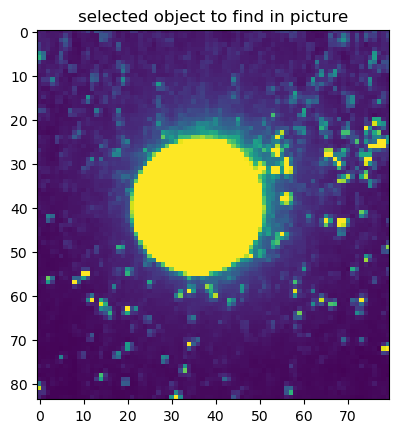

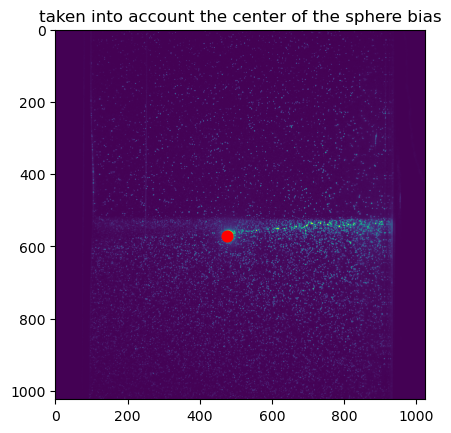

real coordinates =  [476 571]    algorithm coordinates =  (476.0, 571.0)


In [6]:
img_number, real_cor, object_range_cut, prior_knowledge, contrast = Mf.select_circle_napari_advance(pic_folder, to_print=True,
                                                                                    image_number = 58,
                                                                                    sphere_location = [489, 229],
                                                                                    Object_data = [[447, 190], [447, 275], [527, 275], [527, 190]],
                                                                                    PTV_data = [[418, 0], [418, 1024], [563, 1024], [563, 0]])

bias_x, bias_y = object_range_cut[1].start + (object_range_cut[1].stop - object_range_cut[1].start)/2 - real_cor[0], object_range_cut[0].start + (object_range_cut[0].stop - object_range_cut[0].start)/2 - real_cor[1]
im_a_path = picture_list[img_number]
the_selected_image = Mf.read_image(im_a_path)
object_array = the_selected_image[object_range_cut]
corr = Mf.track_object(object_array, im_a_path, bias = [bias_x, bias_y], prior_knowledge = prior_knowledge, show = True)
print('real coordinates = ', real_cor, '   algorithm coordinates = ', corr)

PIV_Range = slice(0,1024), slice(0,1024)

Select PIV range

In [7]:
if True:
    PIV_Range = Mf.select_area_napari_notebook(Mf.find_pictures(pic_folder)[0], 'Select the Area for PIV', rectangle_data = [[123, 458], [123, 648], [926, 648], [926, 458]])

rectangle_data = [[123, 458], [123, 648], [926, 648], [926, 458]]


In [8]:
clean_locations = []
clean_locations_plus_frame = []
relative_locations = []

show the effect of high pass filter

In [9]:
if contrast[0] == 0 and contrast[1] == 255:
    im_a12 = Mf.high_pass_filter(Mf.read_image(picture_list[0]))
else:
    # apply contrast from napari
    im_a12 = Mf.Change_contrast(Mf.read_image(picture_list[0]), contrast)

im_a123 = Mf.edge_enhancement(Mf.read_image(picture_list[0]))
im_a1234 = Mf.edge_enhancement(im_a12)
# Mf.display_images_with_napari_recive_list([Mf.read_image(picture_list[0]), im_a1234], title='Before and after filter')

Apply high pass filter to the images?

In [10]:
high_pass_filter = True
edge_enhancement = True
apply_static_manual_mask = True
sphere_diameter_pixel = 26
see_sphere_location = False
to_print = False

Define PIV parameters

In [11]:
frame_rate = Mf.read_data_from_cihx(pic_folder, return_number=True, return_int=True) # fps
print('frame per second =', frame_rate)
dt = 1/frame_rate # sec

window_size = 32 # pixels
search_area_size = window_size # pixels 
overlap = round(search_area_size/2) # pixels
scale = 0.01 # scale defines here the arrow length
width = 0.002 # width is the thickness of the arrow
threshold = 1.1
u_thresholds = 100



display_plot = True # display plot
print(f'number of pictures in folder {len(picture_list)}')

frame per second = 60
number of pictures in folder 853


In [12]:
def funcy( args ):
    """A function to process each image pair."""

    # this line is REQUIRED for multiprocessing to work
    # always use it in your custom function

    file_a, file_b, counter = args

    #####################
    # Here goes you code
    #####################

    number = int(os.path.splitext(os.path.basename(file_a))[0][-5:])
    the_file_name = 'multy_%04d.txt'
    if Masked:
        the_file_name = the_file_name[:-4] + '_Mask.txt'
    if to_print:
        #Prints
        print(file_a)
        print(file_b)
        print(the_file_name % number)

    # read images into numpy arrays
    im_a = tools.imread(file_a)
    im_b = tools.imread(file_b)


    #finding sphere coordinates
    #cor a cnd corr b are coordinaes of thesphere in each of the images, found by he coorelaton function. in [pixel] with respect the origin (0,0) is top left corner
    corr_a = Mf.track_object(object_array, file_a, bias = [bias_x, bias_y], prior_knowledge = prior_knowledge, show = see_sphere_location)

    #the real spheres location is the interpolation between those two images.
    clean_locations.append(corr_a)
    clean_locations_plus_frame.append([corr_a, number])
    
    frame_aa = im_a
    frame_bb = im_b
    
    if PIV_Range is not None:
        frame_aa = im_a[PIV_Range]
        frame_bb = im_b[PIV_Range]

        #Optional part apply high pass filter if manualy contrasnt has not been specified:
    if high_pass_filter:
        if contrast[0] == 0 and contrast[1] == 255:
            frame_aa = Mf.high_pass_filter(frame_aa)
            frame_bb = Mf.high_pass_filter(frame_bb)
        else: # apply contrast from napari
            frame_aa = Mf.Change_contrast(frame_aa, contrast)
            frame_bb = Mf.Change_contrast(frame_bb, contrast)
    
    if edge_enhancement:
        frame_aa = Mf.edge_enhancement(frame_aa)
        frame_bb = Mf.edge_enhancement(frame_bb)

    #Optional part: static mask
    if apply_static_manual_mask: #manual
        frame_aa = Mf.static_manual_mask(frame_aa, x = corr_a[0] - PIV_Range[1].start, y = corr_a[1] - PIV_Range[0].start, radius = sphere_diameter_pixel)
        
        corr_b = Mf.track_object(object_array, file_b, bias = [bias_x, bias_y], prior_knowledge = prior_knowledge, show = see_sphere_location)
        frame_bb = Mf.static_manual_mask(frame_bb, x = corr_b[0] - PIV_Range[1].start, y = corr_b[1] - PIV_Range[0].start, radius = sphere_diameter_pixel)

    
    
    ##autumatic
    # if apply_static_mask:
        # static_mask_a = Mf.static_mask(frame_aa)
        # static_mask_b = Mf.static_mask(frame_bb)
        # frame_aa[static_mask_a] = 0
        # frame_bb[static_mask_b] = 0

    #Optional part: dynamic mask
    if Masked:
        frame_aa, _ = preprocess.dynamic_masking(frame_aa, method='intensity', filter_size=7, threshold=0.01)
        frame_bb, _ = preprocess.dynamic_masking(frame_bb, method='intensity', filter_size=7, threshold=0.01)
    
    # save image
    the_image_name = 'multy_%04d.tif'
    if Masked:
        the_image_name = the_image_name[:-4] + '_Mask.tif'

    relative_locations.append([corr_a[0] - PIV_Range[1].start, corr_a[1] - PIV_Range[0].start])
    Mf.save_image(os.path.join(multy_cut_image_folder, the_image_name % number), frame_aa)
    

    # PIV analysis
    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_aa.astype(np.int32), 
                                                       frame_bb.astype(np.int32), 
                                                       window_size = window_size, 
                                                       overlap = overlap, 
                                                       dt = dt, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')
    
    x, y = pyprocess.get_coordinates(image_size = frame_aa.shape, 
                                    search_area_size = search_area_size, 
                                    overlap = overlap )


    flags_g = validation.global_val(u, v, (-u_thresholds, u_thresholds), (-u_thresholds, u_thresholds))
    flags_s2n = validation.sig2noise_val(sig2noise, threshold = threshold)
    flags = flags_g | flags_s2n
    u, v = filters.replace_outliers(u, v, flags, method='localmean', max_iter = 5, kernel_size = 3)

    # Turning everything to SI
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = scaling_factor)

    # 0,0 bottom left, positive rotation rate is counterclockwise
    x, y, u, v = tools.transform_coordinates(x, y, u, v)


    # save to a file
    tools.save(os.path.join(save_folder_multy, the_file_name % number), x, y, u, v, flags, None, fmt='%.16e', delimiter='\t')

In [13]:
task = tools.Multiprocesser(data_dir = pathlib.Path(pic_folder), pattern_a = 'C*.tif', pattern_b = '(1+2),(2+3)')
task.run(func = funcy, n_cpus = 1)
clean_locations.append(Mf.track_object(object_array, picture_list[-1], bias = [bias_x, bias_y], prior_knowledge = prior_knowledge))

In [14]:
# Mf.display_images_with_points_napari(pic_folder, clean_locations, title = 'Sphere with point')

In [25]:
display_plot = True
if display_plot:
    cutted_txt_list = Mf.files_in_folder(save_folder_multy, 'txt', full_path=True)
    multy_cut_list = Mf.find_pictures(multy_cut_image_folder)
    for i in range(len(cutted_txt_list)):
        # print(os.path.basename(cutted_txt_list[i]))
        the_vector_folder = Mf.save_vector_field_as_image(cutted_txt_list[i], multy_cut_list[i], scaling_factor=scaling_factor, vector_scale=scale, window_size=window_size,width=width, sphere_loc=relative_locations[i], sphere_size = round(10/1000*scaling_factor))
        # fig, ax = plt.subplots(figsize=(6, 6))
        # tools.display_vector_field(cutted_txt_list[i], ax=ax, scaling_factor = scaling_factor, window_size=window_size,
        #                            scale=scale, width=width, on_img=True, image_name =  multy_cut_list[i])
Mf.display_color_images_with_napari(the_vector_folder, playback_fps=2)
Mf.eliminate_folder(multy_cut_image_folder)

Folder 'c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output\2024 1 24 - Rec 1\Multy\multy_cut_image' has been moved to the recycle bin.


In [16]:
first_image = Mf.read_image(picture_list[0])
x_max_in_pixel, y_max_in_pixel = first_image.shape[1], first_image.shape[0]

#the sphere location of each PIV analsys is the interpolated location of every pair of photos
locations_pixel = np.mean([clean_locations[:-1], clean_locations[1:]], axis=0) # [pixel]
locations_meter = Mf.transform_coordinates_physical(locations_pixel, pic_folder, scaling_factor, origin_point = origin) # [m]


print('Sphere velocity is caluated from sphere_location_PTV.ipynb')

Sphere velocity is caluated from sphere_location_PTV.ipynb


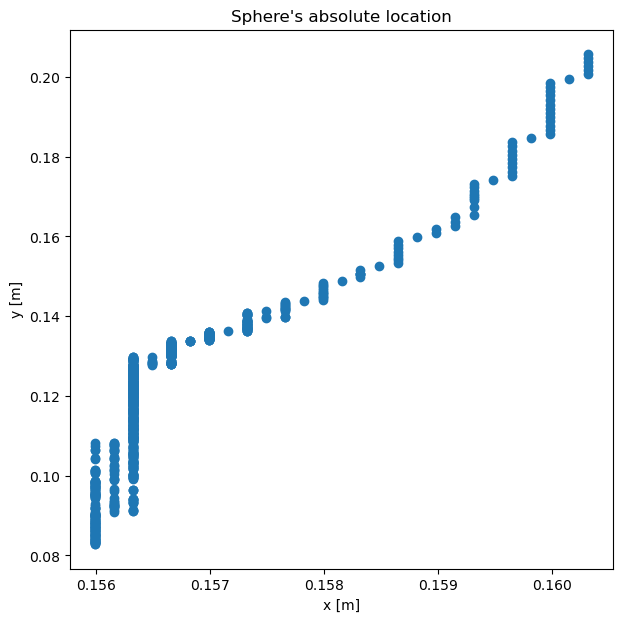

In [17]:
sphere_location = np.array(locations_meter)
x_axis = sphere_location[:, 0]
y_axis = sphere_location[:, 1]


fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(x_axis, y_axis)
# ax.set_xlim(0, 0.2)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title("Sphere's absolute location")
plt.show()

In [18]:
# if also_PTV:
#     #relative location
#     sphere_location_relative=[] #[m]
#     for ind,el in enumerate(locations_meter):
#         sphere_location_relative.append([el[0]-PIV_origin_meters[ind][0], el[1]-PIV_origin_meters[ind][1]]) #[m]
#     sphere_location_relative = np.array(sphere_location_relative)*scaling_factor #[pixel]

In [19]:
# if also_PTV:
#     #for plot
#     first_image = Mf.read_image(picture_list[0])
#     x_max_in_pixel, y_max_in_pixel = first_image.shape[1], first_image.shape[0]
#     sphere_location_relative[:,1] = y_max_in_pixel - sphere_location_relative[:,1]
#     Mf.display_images_with_points_napari(multy_cut_image_folder, sphere_location_relative, title = 'Moving Control Volume - sphere is always at the same location relevant to origin')

Saving

reminder, the positive Y axis is upwards


explain to_save variables
+ locations_meter - the sphere aboslute location in meters relatice to origin.
+ velocitys_meter - sphere velocity in [m/s] SI units
+ PIV_origin_meters - the PIV origin location in [m] with relative to the choosen origin
+ Selected_area_for_PIV - a list of slices on how to slice the original picture to get the PIV rectaingle. for example: img[Selected_area_for_PIV[i]]
+ scaling_factor - [pixel/m] scaling factor
+ object_range_cut - a list of slices on how to slice the original picture to get the rectaingle containing the followed object in the PTV. this will return the object, hence the sphere
+ sphere_location_relative - the sphere location relative to the PIV cutted region, in pixels [pixel]
+ origin - the origin location in pixel [pixel] (as image coordinates y is downwards x is towards the right the img origin is to left corner)

In [20]:
# if also_PTV:
#     to_save = [locations_meter, PIV_origin_meters,
#             Selected_area_for_PIV, scaling_factor, object_range_cut,
#             sphere_location_relative, origin]
    
#     save_file_name = 'data_from_PIV.pkl'
#     if Masked:
#         save_file_name = save_file_name[:-4] + '_Mask.pkl'
#     file_path = os.path.join(save_folder, save_file_name)

#     Mf.save_pickle(file_path, to_save)

add data to existing file

In [21]:
# if also_PTV:
#     to_save = [locations_meter, PIV_origin_meters,
#             Selected_area_for_PIV, scaling_factor, object_range_cut,
#             sphere_location_relative, origin]
    
#     save_file_name = 'data_from_PIV.pkl'
#     if Masked:
#         save_file_name = save_file_name[:-4] + '_Mask.pkl'
#     file_path = os.path.join(save_folder, save_file_name)


#     if os.path.exists(file_path):
#         print('editing file: ', file_path)
#         a = Mf.load_pickle(file_path)
#         b = a[:]
#         b[0] = np.append(a[0], to_save[0], axis = 0)
#         b[1] = np.append(a[1], to_save[1], axis = 0)
#         b[2].append(to_save[2])
#         b[6] = np.append(a[6], to_save[6], axis = 0)
#         b[7] = np.append(a[7], to_save[7], axis = 0)
#         Mf.save_pickle(file_path, b)
#     else:
#         Mf.save_pickle(file_path, to_save)
